In [1]:
import os
from multiprocessing import Pool
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from midi_util import read_midi, produce_song, mute

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
path = os.getcwd() + "/data/"
print("Data path: ", path)

midi_file_paths = [path + i for i in os.listdir(path) if i.endswith(".mid")]
print("# of Files Found: ", len(midi_file_paths))

with Pool(processes=6, initializer=mute) as p: # send excessive output to devnull
    note_data_by_file, dur_data_by_file = zip(*p.starmap(read_midi, zip(midi_file_paths, [False]*len(midi_file_paths))))

print(len(note_data_by_file), len(dur_data_by_file))

Data path:  /Users/danielrjohnson/Documents/OneDrive/Programming/AIO/Music-Generation/data/
# of Files Found:  75
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
75 75


In [3]:
#list comp to flatten
flattened_note_data = [element for note_ in note_data_by_file for element in note_]
print("# of Notes Total: ", len(flattened_note_data))

all_unique_notes = list(set(flattened_note_data))
print("# of Unique Notes: ", len(all_unique_notes))

# of Notes Total:  56365
# of Unique Notes:  88


In [4]:
note_counts = dict(Counter(flattened_note_data))

MIN_COUNT = 25
frequent_notes = [note_ for note_, count in note_counts.items() if count >= MIN_COUNT]
print("# of Notes Occurring At Least", MIN_COUNT, "Times: ", len(frequent_notes))

# of Notes Occurring At Least 25 Times:  78


In [5]:
freq_note_data = [list(filter(lambda x: x in frequent_notes, midi_data)) for midi_data in note_data_by_file]
freq_note_data = np.array(freq_note_data, dtype=object)

In [6]:
n_timesteps = 32
X, y_note, y_duration = [], [], []

for notes_of_file, durations_of_file in zip(note_data_by_file, dur_data_by_file): #freq_note_data:
    for i in range(0, len(notes_of_file) - n_timesteps):
        # (n_timesteps) length note sequence
        X.append([notes_of_file[i:i + n_timesteps], durations_of_file[i:i + n_timesteps]])
        # the note following that sequence
        y_note.append(notes_of_file[i + n_timesteps])
        # the duration of the note following that sequence
        y_duration.append(durations_of_file[i + n_timesteps])


X = np.array(X)
y_note = np.array(y_note)
y_duration = np.array(y_duration)

In [7]:
print(np.unique(y_note))
print(len(np.unique(y_note)))

['A0' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'B-0' 'B-1' 'B-2' 'B-3' 'B-4'
 'B-5' 'B-6' 'B-7' 'B0' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'C#1' 'C#2'
 'C#3' 'C#4' 'C#5' 'C#6' 'C#7' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'D1' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'E-1' 'E-2' 'E-3' 'E-4' 'E-5' 'E-6'
 'E-7' 'E1' 'E2' 'E3' 'E4' 'E5' 'E6' 'E7' 'F#1' 'F#2' 'F#3' 'F#4' 'F#5'
 'F#6' 'F#7' 'F1' 'F2' 'F3' 'F4' 'F5' 'F6' 'F7' 'G#1' 'G#2' 'G#3' 'G#4'
 'G#5' 'G#6' 'G#7' 'G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7']
88


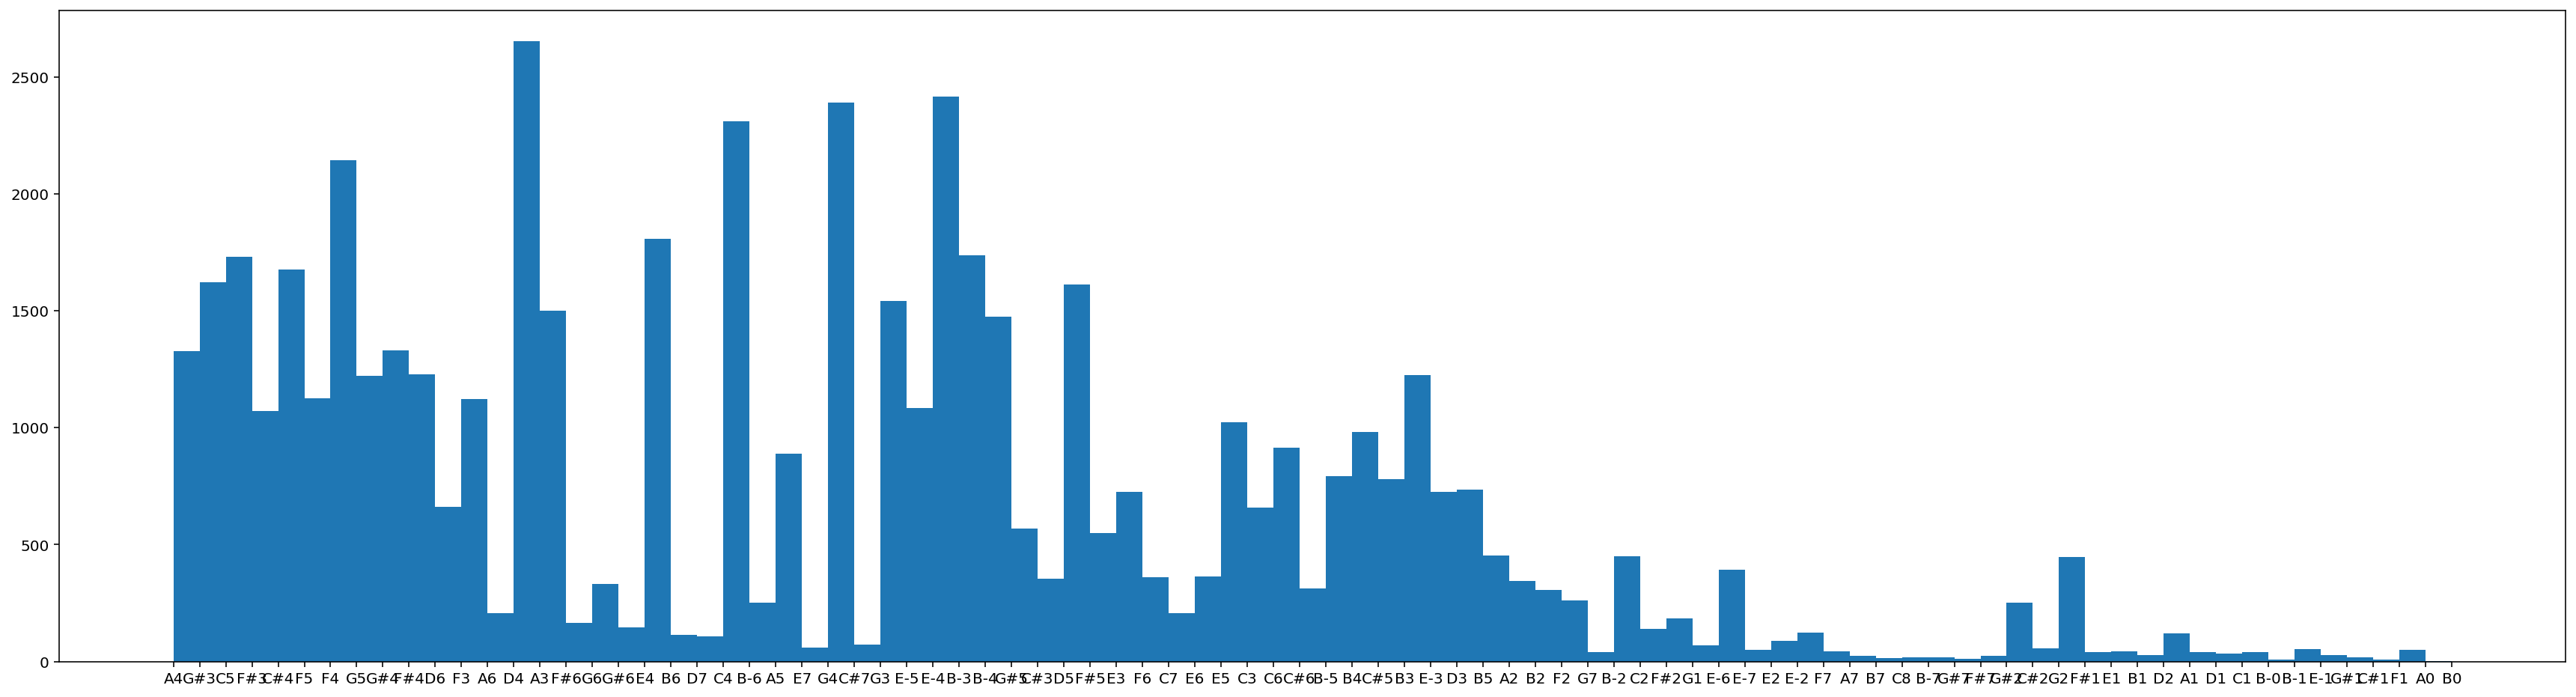

In [8]:
# make the figsize a bigger
plt.figure(figsize=(30, 8))
plt.hist(y_note, bins=np.arange(0, len(np.unique(y_note)), 1))
plt.show()

In [9]:
unique_x_note = list(set(X[:, 0].ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x_note))
x_seq_note = np.array([[x_note_to_int[note] for note in row] for row in X[:, 0]])

unique_x_dur = list(set(X[:, 1].ravel()))
x_dur_to_int = dict((duration, number) for number, duration in enumerate(unique_x_dur))
x_seq_dur = np.array([[x_dur_to_int[duration] for duration in row] for row in X[:, 1]])

# ([Nx32x1], [Nx32x1]) -> ([Nx32x2])
x_seq_combined = np.array(
    [ [ [note, duration] for note, duration in zip(row_note, row_dur) ]
        for row_note, row_dur in zip(x_seq_note, x_seq_dur) ]
)
print("combined note and duration array shape:", x_seq_combined.shape)

unique_y_note = list(set(y_note))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y_note)) 
y_seq_note = np.array([y_note_to_int[note] for note in y_note], dtype=float)

unique_y_duration = list(set(y_duration))
y_dur_to_int = dict((duration_, number) for number, duration_ in enumerate(unique_y_duration))
y_seq_dur = np.array([y_dur_to_int[duration] for duration in y_duration], dtype=float)

combined note and duration array shape: (54765, 32, 2)


In [10]:
x_tr_note, x_val_note, y_tr_note, y_val_note = train_test_split(x_seq_combined[:, :, 0], y_seq_note, test_size=0.2, random_state=0)
x_tr_dur, x_val_dur, y_tr_dur, y_val_dur = train_test_split(x_seq_combined[:, :, 1], y_seq_dur, test_size=0.2, random_state=0)

In [11]:
inputs = Input((n_timesteps, 1))
x = Dense(128, activation="relu")(inputs)
x = LSTM(128)(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(unique_x_note), activation="softmax")(x)

model_note = tf.keras.Model(inputs, output)

model_note.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model_note.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 1)]           0         
_________________________________________________________________
dense (Dense)                (None, 32, 128)           256       
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 88)                11352     
Total params: 159,704
Trainable params: 159,704
Non-trainable params: 0
_________________________________________________________________


(43812, 32) (43812,)
Epoch 1/2
172/172 [==============================] - 7s 39ms/step - loss: 4.1226 - val_loss: 3.9067

Epoch 00001: val_loss improved from inf to 3.90674, saving model to models/best_model_note.h5
Epoch 2/2
172/172 [==============================] - 6s 33ms/step - loss: 3.8899 - val_loss: 3.8655

Epoch 00002: val_loss improved from 3.90674 to 3.86554, saving model to models/best_model_note.h5


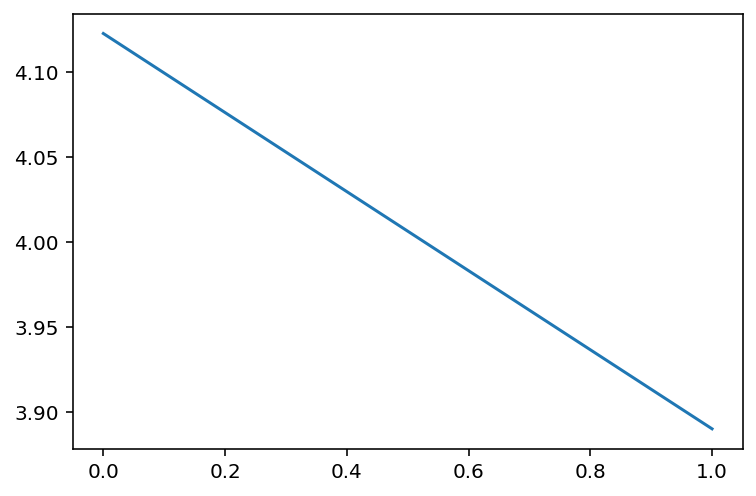

In [12]:
mc = ModelCheckpoint('models/best_model_note.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

device = tf.device('/device:GPU:0') if tf.config.list_physical_devices("GPU") else tf.device('/device:CPU:0')
print(x_tr_note.shape, y_tr_note.shape)
with device:
    history = model_note.fit(x=x_tr_note, y=y_tr_note,
                        batch_size=256, epochs=50, 
                        validation_data=(x_val_note, y_val_note),
                        verbose=1, callbacks=[mc]
    )
plt.plot(history.history['loss'])
plt.show()

In [13]:
inputs = Input((n_timesteps, 1))
x = Dense(128, activation="relu")(inputs)
x = LSTM(128)(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(unique_x_dur), activation="softmax")(x)

model_dur = tf.keras.Model(inputs, output)

model_dur.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model_dur.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 1)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 32, 128)           256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 11)                1419      
Total params: 149,771
Trainable params: 149,771
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2
172/172 [==============================] - 7s 35ms/step - loss: 1.7669 - val_loss: 1.6024

Epoch 00001: val_loss improved from inf to 1.60241, saving model to models/best_model_dur.h5
Epoch 2/2
172/172 [==============================] - 6s 32ms/step - loss: 1.6129 - val_loss: 1.5919

Epoch 00002: val_loss improved from 1.60241 to 1.59193, saving model to models/best_model_dur.h5


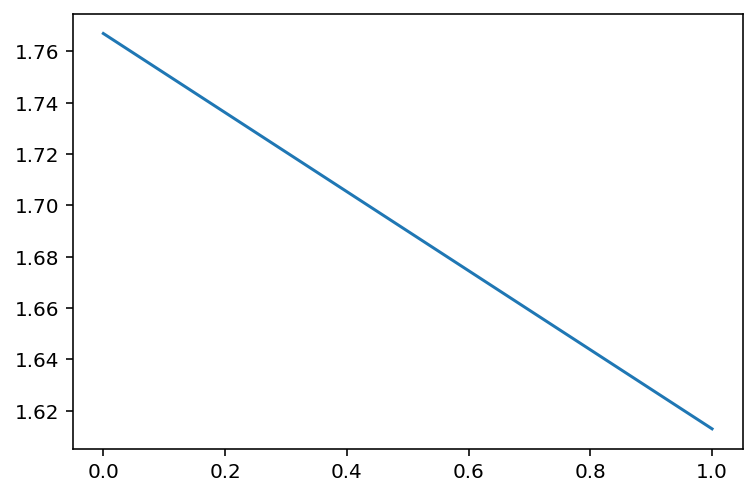

In [14]:
mc = ModelCheckpoint('models/best_model_dur.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

device = tf.device('/device:GPU:0') if tf.config.list_physical_devices("GPU") else tf.device('/device:CPU:0')

with device:
    history = model_dur.fit(x=x_tr_dur, y=y_tr_dur,
                        batch_size=256, epochs=50, 
                        validation_data=(x_val_dur, y_val_dur),
                        verbose=1, callbacks=[mc]
    )
plt.plot(history.history['loss'])
plt.show()

In [15]:
# initial_note_sequence = x_val_note[np.random.randint(0, len(x_val_note))]
# initial_duration_sequence = x_val_dur[np.random.randint(0, len(x_val_dur))]
initial_note_sequence = x_val_note[np.random.randint(0, len(x_val_note))]
initial_duration_sequence = x_val_dur[np.random.randint(0, len(x_val_dur))]
x_int_to_note = {v: k for k, v in x_note_to_int.items()}
x_int_to_dur = {v: k for k, v in x_dur_to_int.items()}

produce_song(initial_note_sequence, initial_duration_sequence, x_int_to_note, 
                x_int_to_dur, n_notes=50, midi_file_path="songs/song.mid")

[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4', 'E-4']
['eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eighth', 'eight